In [8]:
import rasterio
from rasterio.enums import Resampling
import numpy as np

def merge_band(rgb_image_path, height_image_path, output_filename):
    with rasterio.open(rgb_image_path) as src:
        # Read the source image data
        source_data = src.read().astype('float32')
        profile = src.profile.copy()
        profile.update(dtype='float32')

        # Open the target image in write mode
        with rasterio.open(output_filename, 'w', **profile) as tgt:
            # Write the source image data to the target image
            tgt.write(source_data)

    with rasterio.open(height_image_path) as src:
        # Read the source image data
        source_data = src.read(1).astype('float32')
        profile = src.profile.copy()
        profile.update(dtype='float32')
        # Open the target image in write mode
        with rasterio.open(output_filename, 'r+', **profile) as tgt:
            # Write the source image data to the target image
            tgt.write(source_data, 4)

    with rasterio.open(rgb_image_path) as mask_src:
        mask = mask_src.read(1)  # Assuming the mask is in the first band
        mask = mask.astype(bool)  # Convert to boolean mask

    # Open the source image in read mode
    with rasterio.open(output_filename) as src:
        # Read the source image data
        source_data = src.read()

        # Apply the mask to the source data
        masked_data = source_data * mask.astype(source_data.dtype)

        # Update metadata for target file
        profile = src.profile.copy()

        # Open the target image in write mode
        with rasterio.open(output_filename, 'w', **profile) as tgt:
            # Write the masked data to the target image
            tgt.write(masked_data)


In [13]:
file1 = "out/sun_hoa_binh_cuoi_ha_2.tif"
file2 = 'out/sun_hoa_binh_cuoi_ha_2_height.tif'
output_filename = 'out/sun_hoa_binh_cuoi_ha_2_4b.tif'
merge_band(file1, file2, output_filename)

In [1]:
import json
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import os
import shutil
import numpy as np
import tifffile as tiff

def create_mask_from_json(json_path, image_path, output_dir):
    image_base_name = os.path.basename(image_path) #get file name, e.g 'kho_xang_.tif'

    # Đọc tập tin .json chứa thông tin về nhãn
    with open(json_path, 'r') as file:
        data = json.load(file)

    shapes = data.get("shapes", [])  # Lấy danh sách các hình đa giác

    # Đọc ảnh vệ tinh
    img = Image.open(image_path)

    # Tạo ảnh mask mới với kích thước và định dạng như ảnh vệ tinh
    mask = Image.new("L", img.size, 0)
    draw = ImageDraw.Draw(mask)

    # Lặp qua danh sách các hình đa giác và tô màu trắng vào các vùng đa giác biểu diễn nhãn
    for shape in shapes:
        points = shape.get("points", [])
        xy = [tuple(map(int, p)) for p in points]
        draw.polygon(xy, outline=1, fill=1)

    # Chuyển mask thành mảng numpy và điều chỉnh màu sắc
    mask_array = np.array(mask)
    mask_array[mask_array == 1] = 255



    # Lưu mask vào tập tin .tif
    mask_dir = os.path.join(output_dir)
    os.makedirs(mask_dir, exist_ok=True)
    image_name = os.path.splitext(os.path.basename(image_base_name))[0]
    mask_path = os.path.join(mask_dir, image_name + "_grass.tif") #save the output file as .tif

    # if file already exists, remove it
    if os.path.isfile(mask_path):
      os.remove(mask_path)
    tiff.imwrite(mask_path, mask_array)



In [3]:
json_path = 'out/sun_hoa_binh_cuoi_ha_2.json'
image_path = 'out/sun_hoa_binh_cuoi_ha_2.tif'
output_dir = 'out'
create_mask_from_json(json_path, image_path, output_dir)

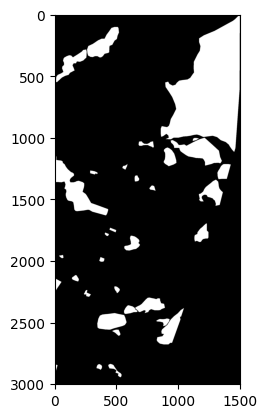

In [4]:
import cv2
import matplotlib.pyplot as plt
img = cv2.imread('out/sun_hoa_binh_cuoi_ha_2_grass.tif')
plt.imshow(img, cmap='gray')

In [ ]:
import geopandas as gpd
import rasterio
from rasterio.mask import mask
from shapely.geometry import box
import argparse
import os
def crop(input_tiff_path, output_tiff_path, crs, minx, miny, maxx, maxy):
    print(f"Crop {minx}, {maxx}, {miny}, {maxy}")
    bbox = box(minx, miny, maxx, maxy)
    bbox_gdf = gpd.GeoDataFrame({'geometry': bbox}, index=[0], crs=crs)

    with rasterio.open(input_tiff_path) as src:
        out_image, out_transform = mask(src, bbox_gdf.geometry, crop=True)
        out_meta = src.meta.copy()

    out_meta.update({"driver": "GTiff",
                    "height": out_image.shape[1],
                    "width": out_image.shape[2],
                    "transform": out_transform})

    with rasterio.open(output_tiff_path, "w", **out_meta) as dest:
        dest.write(out_image)

def get_file_name(file_path):
    file_name, file_extension = os.path.splitext(file_path)
    return os.path.basename(file_name)
    
def main(input_tiff_path, output_dir, width=512, height=512):
    dataset = rasterio.open(input_tiff_path)
    img_width = dataset.width
    img_height = dataset.height

    ct = 0
    file_name = get_file_name(input_tiff_path)

    for i in range(0, img_height, height):
        for j in range(0, img_width, width):
            minx, miny = dataset.xy(i, j)
            maxx, maxy = dataset.xy(min(i+height, img_height), min(j+width, img_width))

            crop(input_tiff_path, os.path.join(out_dir, f'{file_name}_{ct}.tif'), dataset.crs, minx, miny, maxx, maxy)
            ct += 1


ModuleNotFoundError: No module named 'geopandas'

In [ ]:
            
# if __name__ == "__main__":
#     parser = argparse.ArgumentParser(description="CROP FILE")
#     parser.add_argument("--input", help="input path")
#     parser.add_argument("--out_dir", help="output directory")
#     parser.add_argument("--width", help="width")
#     parser.add_argument("--height", help="height")
#     args = parser.parse_args()

#     input_tiff_path = args.input
#     out_dir = args.out_dir
#     width, height = int(args.width), int(args.height)

#     if not os.path.exists(out_dir):
#         # If not, create the folder
#         os.makedirs(out_dir)

#     dtm_path = main(input_tiff_path, out_dir, width, height)


In [8]:
import rasterio
data1 = rasterio.open("out/sun_hoa_binh_cuoi_ha_2.tif")
data2 = rasterio.open("scene/sun_hoa_binh_cuoi_ha.tif")

width1, height1 = data1.width, data1.height
width2, height2 = data2.width, data2.height

print(height1, width1)
print(height2, width2)

3001 1501
13526 5058


In [9]:
top_left = data1.xy(0, 0)
bot_right = data1.xy(height1-1, width1-1)

print(top_left, bot_right)

(557510.2880800001, 2279894.9245400005) (557960.2880800001, 2278994.9245400005)


In [10]:
row1, col1 = data2.index(*top_left)
row2, col2 = data2.index(*bot_right)

print(row1, col1)
print(row2, col2)

8000 3500
11000 5000
